In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs

# Optimization and Bayesian Optimization libraries
import torch
from botorch.utils.transforms import normalize, unnormalize
from boclass_aqui import PoolObjectives, Models

import random
from joblib import Parallel, delayed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double


cpu


In [3]:
all_data = pd.read_csv('../all_data.csv') # all_df = pd.concat([data01, data2A, data2B, data2C, data3A, data3B, data3C], axis=0, ignore_index=True)

# Iteration 0: Set up gp with initial data
original_bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)

x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]
# Set the device and dtype

# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=dtype, device=device)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=dtype, device=device)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=dtype, device=device)

seed = 1
random.seed(seed)
train_size = 2
random_indices = random.sample(range(x_all.shape[0]), train_size)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

y_train = y_all[random_indices]
y_train_var = yvar_all[random_indices]

# Set up the Pool
x_train_np = x_train.cpu().numpy()
# Find all rows in x_inputs that are not in x_train
mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]

# Set up the Gaussian Process and query
query = PoolObjectives(x_input_new, y_output_new ,yvar_output_new, columns=['time', 'temp', 'sulf', 'anly'])
# Step 1: Initialize your model
EI_model = Models(aqui_func='EI', x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=1, objective=query)
UCB_model = Models(aqui_func='UCB', x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=1, objective=query)
PI_model = Models(aqui_func='PI', x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=1, objective=query)


In [ ]:
from tqdm.notebook import tqdm
from IPython.display import display

def BO_loop(aqui_func, gp_model, train_nx, train_y, train_yvar, x_all, y_all, yvar_all, iterations=5):
    store_gp = []
    query = PoolObjectives(x_all, y_all, yvar_all, columns=['time', 'temp', 'sulf', 'anly'])
    
    progress = tqdm(total=iterations, desc="BO Iterations", leave=True)  # put progress bar here
    
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.regular_candidates()
        
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)

        nx_train = normalize(x_actual, bounds=original_bounds)
        
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        
        # Instantiate and train model
        gp_model = Models(
            aqui_func=aqui_func,
            x_train=train_nx,
            y_train=train_y,
            y_train_var=train_yvar,
            bounds=original_bounds,
            batch_size=1,
            objective=query,
            random_id=seed
        )
        store_gp.append(gp_model)
        
        progress.update(1)  # update after each iteration

    progress.close()
    
    print(used_id)
    return store_gp, train_nx, train_y, train_yvar



In [13]:
num = 105-train_size
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]

ExpImp, EI_x, EI_y,EI_yvar = BO_loop('EI',EI_model,x_train, y_train,y_train_var,  x_input_new, y_output_new, yvar_output_new,iterations=num)


BO Iterations:   0%|          | 0/103 [00:00<?, ?it/s]

BO Iterations: 100%|##########| 103/103 [02:08<00:00,  1.69s/it]

[np.int64(73)]


In [14]:
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]

UppCB, UCB_x, UCB_y, UCB_yvar = BO_loop('UCB',UCB_model,x_train, y_train,y_train_var,  x_input_new, y_output_new, yvar_output_new,iterations=num)


BO Iterations:   0%|          | 0/103 [00:00<?, ?it/s]

BO Iterations: 100%|##########| 103/103 [01:24<00:00,  1.21s/it]

[np.int64(73)]


In [15]:
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]
ProbImp, PI_x, PI_y, PI_yvar = BO_loop('PI',PI_model,x_train, y_train,y_train_var,  x_input_new, y_output_new, yvar_output_new,iterations=num)


BO Iterations:   0%|          | 0/103 [00:00<?, ?it/s]

BO Iterations: 100%|##########| 103/103 [02:32<00:00,  1.62s/it]

[np.int64(73)]


# plots

In [ ]:
# Generate a 4D test_x grid within the normalized bounds [0, 1] for each dimension
num_points_per_dim = 10
grid_axes = [np.linspace(0, 1, num_points_per_dim) for _ in range(4)]
mesh = np.meshgrid(*grid_axes, indexing='ij')
test_x = np.stack([m.flatten() for m in mesh], axis=-1)
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

EI_var_sum = [EI_model.gp_evaluate(test_x, 'Regular')[1].sum().item()]
UCB_var_sum = [UCB_model.gp_evaluate(test_x, 'Regular')[1].sum().item()]
PI_var_sum = [PI_model.gp_evaluate(test_x, 'Regular')[1].sum().item()]
EI_mean_all = [EI_model.gp_evaluate(test_x, 'Regular')[0]]
UCB_mean_all = [UCB_model.gp_evaluate(test_x, 'Regular')[0]]
PI_mean_all = [PI_model.gp_evaluate(test_x, 'Regular')[0]]
EI_rmse = []
UCB_rmse = []
PI_rmse = []
for i in range(len(ExpImp)):
    _, EI_var = ExpImp[i].gp_evaluate(test_x, 'Regular')
    _, UCB_var = UppCB[i].gp_evaluate(test_x,'Regular')
    _, PI_var = ProbImp[i].gp_evaluate(test_x,'Regular')

    EI_mean, _ = ExpImp[i].gp_evaluate(x_all, 'Regular')
    UCB_mean, _ = UppCB[i].gp_evaluate(x_all, 'Regular')
    PI_mean, _ = ProbImp[i].gp_evaluate(x_all, 'Regular')

    # Store the results
    EI_var_sum.append(EI_var.sum().item())
    UCB_var_sum.append(UCB_var.sum().item())
    PI_var_sum.append(PI_var.sum().item())
    EI_rmse.append(torch.sqrt(torch.mean((torch.tensor(EI_mean) - y_all))** 2))
    UCB_rmse.append(torch.sqrt(torch.mean((torch.tensor(UCB_mean) - y_all))** 2))
    PI_rmse.append(torch.sqrt(torch.mean((torch.tensor(PI_mean) - y_all))** 2))

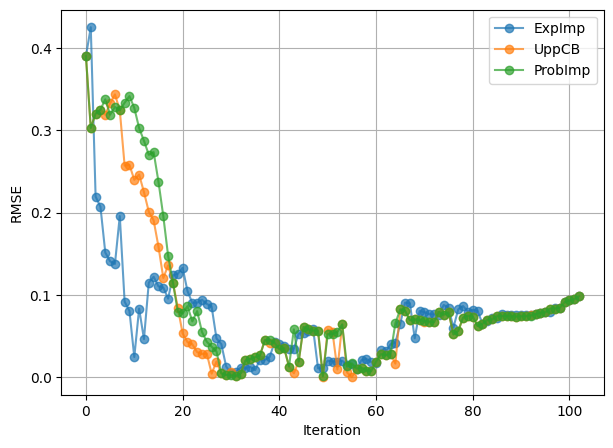

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(EI_rmse)),  (EI_rmse), marker='o', label='ExpImp', alpha=0.7)
plt.plot(range(len(UCB_rmse)), (UCB_rmse), marker='o', label='UppCB', alpha=0.7)
plt.plot(range(len(PI_rmse)),  (PI_rmse), marker='o', label='ProbImp', alpha=0.7)

plt.xlabel('Iteration')
plt.ylabel('RMSE')
# plt.title('Expected Improvement (EI_y) vs Iterations')
plt.grid(True)
plt.legend()
plt.show()

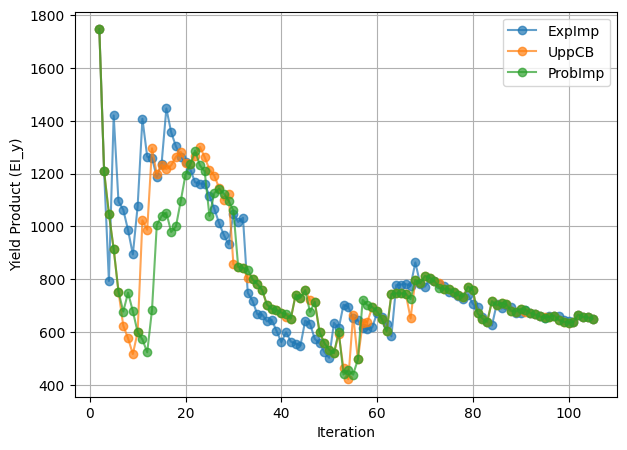

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(train_size, len(EI_y) + 1), (EI_var_sum), marker='o', label='ExpImp', alpha=0.7)
plt.plot(range(train_size, len(UCB_y) + 1), (UCB_var_sum), marker='o', label='UppCB', alpha=0.7)
plt.plot(range(train_size, len(PI_y) + 1), (PI_var_sum), marker='o', label='ProbImp', alpha=0.7)

plt.xlabel('Iteration')
plt.ylabel('Yield Product (EI_y)')
# plt.title('Expected Improvement (EI_y) vs Iterations')
plt.grid(True)
plt.legend()
plt.show()

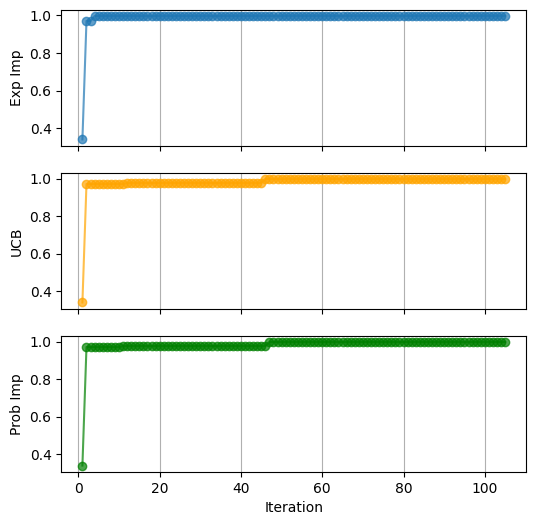

In [ ]:
# Find the best (maximum) y found up to each iteration for each acquisition function
ei_best_y = [float(EI_y[:i+1].max()) for i in range(len(EI_y))]
ucb_best_y = [float(UCB_y[:i+1].max()) for i in range(len(UCB_y))]
pi_best_y = [float(PI_y[:i+1].max()) for i in range(len(PI_y))]

fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

iterations = 105
axs[0].plot(range(1,iterations+1), ei_best_y, marker='o', label='ExpImp', alpha=0.7)
axs[0].set_ylabel('Exp Imp')
axs[0].grid(axis='x')
# axs[0].set_xticks(range(1, ))

axs[1].plot(range(1,iterations+1), ucb_best_y, marker='o', label='UppCB', alpha=0.7, color='orange')
axs[1].set_ylabel('UCB')
# axs[1].set_xticks(range(1, iterations+1))
axs[1].grid(axis='x')

axs[2].plot(range(1,iterations+1), pi_best_y, marker='o', label='ProbImp', alpha=0.7, color='green')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Prob Imp')
# axs[2].set_xticks(range(1, iterations+1))
axs[2].grid(axis='x')


# plt.suptitle('Best Yield Found per Iteration (Separate Subplots)')


# plt.xlabel('Iteration')
# plt.ylabel('Best Yield Found')
# # plt.title('Best Yield Found per Iteration')
# plt.grid(True)
# plt.legend()
plt.show()